In [1]:
import nibabel as nib
import numpy as np
from sklearn.cluster import KMeans
import os
import cv2

In [2]:
def intensity_clustering(input_path, output_path, n_clusters=3):
    
    img = nib.load(input_path)
    img_data = img.get_fdata()
    flat_data = img_data.reshape(-1, 1)
    
    tissue_mask = flat_data != 0
    tissue_part = flat_data[tissue_mask].reshape(-1, 1)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(tissue_part)
    
    tissue_clustered_label= kmeans.labels_ # get the clustering results of tissue
    image_clustered = np.zeros_like(flat_data) # zero array to store results
    image_clustered[tissue_mask] = tissue_clustered_label+1 # insert results in the zore array
    
    image_clustered = image_clustered.reshape(img_data.shape) # reshape
    new_img = nib.Nifti1Image(image_clustered.astype(np.int16), img.affine, img.header)
    nib.save(new_img, output_path)
    
    print(f"Clustering result saved as {output_path}")
    return image_clustered

In [ ]:
n = 3
input_dir = ''
output_dir = f'/Users/zilianghong/Documents/IPMN/T1/Cluster_label/Clusters_{3}'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
for name in os.listdir(input_dir):
    if name.endswith('.nii.gz'):
        input_path = os.path.join(input_dir,name)
        output_path = os.path.join(output_dir,name)
        c_data = intensity_clustering(input_path=input_path,output_path=output_path,n_clusters=n)
        print(f"Clustering result saved as {output_path}")

In [1]:
import numpy as np
from scipy.linalg import eigh
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

In [27]:
X, y = make_moons(n_samples=6000, noise=0.1, random_state=42)
# X = X[:,1].reshape(3000,1)

In [28]:
np.shape(X)

(6000, 2)

In [29]:
def rbf_kernel(X, gamma=1.0):
    pairwise_sq_dists = np.sum((X[:, np.newaxis] - X[np.newaxis, :]) ** 2, axis=2)
    return np.exp(-gamma * pairwise_sq_dists)

similarity_matrix = rbf_kernel(X, gamma=15.0)

In [30]:
np.shape(similarity_matrix)

(6000, 6000)

In [31]:
# Degree matrix
degree_matrix = np.diag(similarity_matrix.sum(axis=1))
# Laplacian matrix
laplacian_matrix = degree_matrix - similarity_matrix

In [32]:
# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(laplacian_matrix)

# Select the eigenvectors corresponding to the smallest k eigenvalues
k = 3
selected_eigenvectors = eigenvectors[:, :k]

In [24]:
selected_eigenvectors.shape

(3000, 3)

In [25]:
from sklearn.cluster import KMeans

# Perform k-means clustering
kmeans = KMeans(n_clusters=k)
kmeans.fit(selected_eigenvectors)
labels = kmeans.labels_

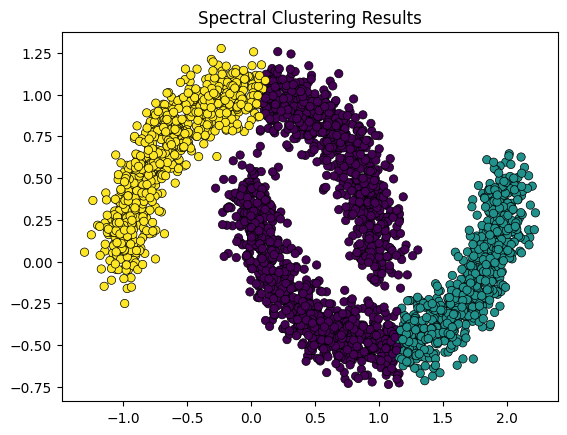

In [26]:
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', lw=0.5, edgecolor='k')
plt.title("Spectral Clustering Results")
plt.show()